# Perceptrón Multicapa Imperative/Training loop
- Objetivo: Programar un MLP en notación orientada a objetos con Tensorflow 2
- Los modelos son más personalizables para tareas como investigación

https://blog.tensorflow.org/2019/01/what-are-symbolic-and-imperative-apis.html

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

In [2]:
data = load_breast_cancer()

In [3]:
X_data = data.data
y_data = data.target

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.33, random_state = 23) 

In [5]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(381, 30)
(188, 30)
(381,)
(188,)


In [6]:
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)


In [7]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

## Crear modelo
- Se crea una clase, las capas se definen en el constructor y el método call indica el flujo

In [8]:
class MLP(Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.d1 = Dense(30, activation='sigmoid', name='input')
        self.d2 = Dense(20, activation='sigmoid', name='hidden')
        self.d3 = Dense(1, activation='sigmoid', name='output')

    def call(self, x): # método call que pasa 'x' por capa
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)


In [9]:
model = MLP()
model.build(input_shape=(None, 30))
model.summary()

Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                multiple                  930       
_________________________________________________________________
hidden (Dense)               multiple                  620       
_________________________________________________________________
output (Dense)               multiple                  21        
Total params: 1,571
Trainable params: 1,571
Non-trainable params: 0
_________________________________________________________________


- Optimizador y función de costo

In [10]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.SGD()

- Métricas

In [11]:
train_loss = tf.keras.metrics.BinaryCrossentropy(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

- Listas para plot

In [12]:
hist_loss = []
hist_acc = []

# Entrenamiento
- Se hace un ciclo por épocas en donde se itera por cada época sobre cada par de datos y etiquetas de entrenamiento

- *Nota: El entrenamiento con 'tf.function decorator' tiene un mejor desempeño al compilarse en grafo. Para simplificar el ejemplo, también se omite el entrenamiento en conjunto de prueba*

In [13]:
EPOCH = 20
for epoch in range(EPOCH):
    #entrenamiento
    for data, target in train_ds:
        with tf.GradientTape() as tape:
            predictions = model(data)# predicciones
            loss = loss_fn(target, predictions) # target y predicciones para obtener acc
        gradients = tape.gradient(loss, model.trainable_variables) # gradiente sobre variables entrenables
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        # se guardan metricas
        train_loss(target, predictions)
        train_accuracy(target, predictions)
    

    template = 'Epoch {}/{} \n - loss: {} - accuracy: {}'
    print(template.format(epoch+1, EPOCH,
                        train_loss.result(), train_accuracy.result()))
    # lista para plot
    hist_loss.append(train_loss.result())
    hist_acc.append(train_accuracy.result())
    # reinicia las metricas para la siguiente epoca
    train_loss.reset_states()
    train_accuracy.reset_states()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/20 
 - loss: 0.6844579577445984 - accuracy: 0.6170976758003235
Epoch 2/20 
 - loss: 0.6588442921638489 - accuracy: 0.7556573748588562
Epoch 3/20 
 - loss: 0.6512103080749512 - accuracy: 0.7567349076271057
Epoch 4/20 
 - loss: 0.6424896121025085 - accuracy: 0.6350574493408203
Epoch 5/20 
 - loss: 0.6406248211860657 - accuracy: 0.6350574493408203
Epoch 6/20 
 - loss: 0.6302149295806885 - accuracy: 0.6350574493408203
Epoch 7/20 
 - loss: 0.6354005932807922 - accuracy: 0.6347880959510803
Epoch 8/20 

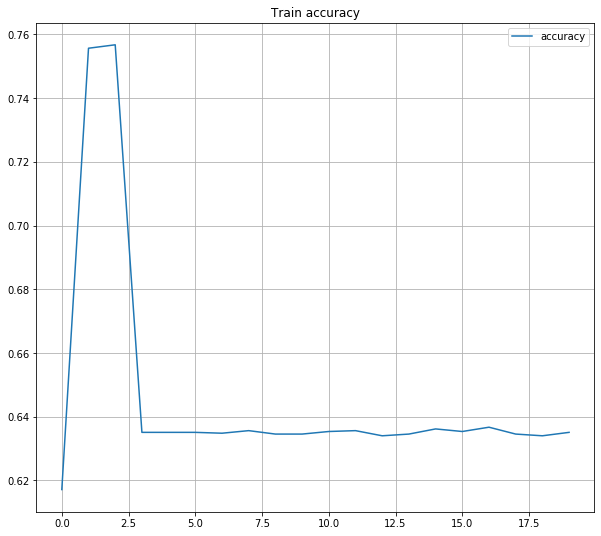

In [14]:
plt.figure(figsize=(10,9))
plt.plot(np.arange(len(hist_acc)), hist_acc)
plt.title('Train accuracy')
plt.legend(['accuracy'])
plt.grid()

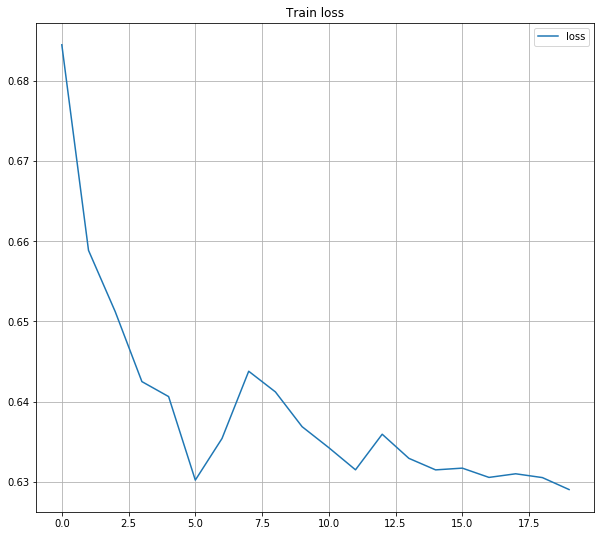

In [15]:
plt.figure(figsize=(10,9))
plt.plot(np.arange(len(hist_loss)), hist_loss)
plt.title('Train loss')
plt.legend(['loss'])
plt.grid()

- Mejorar el modelo
- Agregar conjunto de validación
- Implementar con otro dataset